In [39]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graph_traffic.custom_funcs import  rows_no_change

id_t = 3396

path = '../data/processed/'

tpath = path + 'trafico/'
filestpath = tpath + 'files_per_loc/'

mpath = path + 'meteo/'
filesmpath = mpath + 'files_per_station/'

tmagns = ['intensidad', 'ocupacion', 'vmed']
mmagns = ['temperatura', 'humedad_relativa', 'presion_barometrica', 'radiacion_solar',
          'precipitacion', 'vientox', 'vientoy']

mapping = pd.read_csv(path + 'id_mapping.csv')
ids_m = mapping[mapping.id_t == id_t].iloc[0][[f'id_{magn}' for magn in mmagns]].astype(int)


dft = pd.read_csv(filestpath + f'{id_t:.0f}.csv', parse_dates=['fecha'], index_col='fecha')
#dfm = pd.read_csv(filesmpath + f'estacion-{id_m:.0f}.csv', parse_dates=['fecha'], index_col='fecha')
dfm = {estacion: pd.read_csv(filesmpath + f'estacion-{estacion:.0f}.csv', parse_dates=['fecha'], index_col='fecha') for estacion in ids_m.unique()}

nt = dft[tmagns].apply(rows_no_change)
for m in tmagns:
    dft[m] = np.where(nt[m]>4, np.nan, dft[m])
    

for estacion, dfmi in dfm.items():
    nm = dfmi[mmagns].apply(rows_no_change)
    for m in mmagns:
        if m in ['precipitacion', 'radiacion_solar', 'presion_barometrica']:
            continue
        dfmi[m] = np.where((nm[m]>4) & (dfmi[m]!=0), np.nan, dfmi[m])
        
df = dft
for m in mmagns:
    df = df.merge(dfm[ids_m[f"id_{m}"]][[m]],
                 left_index=True, right_index=True,
                how='left')
df = df.sort_index()
df[mmagns] = df[mmagns].fillna(method="ffill", limit=4)

cal = pd.read_csv(path+'calendario.csv', sep=';')
cal['fecha'] = pd.to_datetime(cal['Día'], dayfirst=True)
cal['laborable / festivo / domingo festivo'] = cal['laborable / festivo / domingo festivo'].str.lower()
festivos = cal[cal['laborable / festivo / domingo festivo']=='festivo'].fecha.dt.date.unique()

df['dia_semana'] = df.index.day_of_week
df.loc[df.dia_semana < 5, 'tipo_dia'] = 'laborable'
df.loc[df.dia_semana == 5, 'tipo_dia'] = 'sabado'
df.loc[(df.dia_semana == 6 ) | (pd.Series(df.index.date).isin(festivos)), 'tipo_dia'] = 'domingo/festivo'
df = df.merge(df.tipo_dia.str.get_dummies().iloc[:, [1, 2]], left_index=True, right_index=True)
del df['dia_semana'], df['tipo_dia']

timestamp_s = df.index.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['dia_sen'] = np.sin(timestamp_s * (2 * np.pi / day))
df['dia_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['ano_sen'] = np.sin(timestamp_s * (2 * np.pi / year))
df['ano_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df.head()

intensidad  ocupacion  vmed  temperatura  \
fecha                                                           
2020-01-01 00:00:00        64.0        NaN   NaN          NaN   
2020-01-01 00:15:00        69.0        NaN   NaN          NaN   
2020-01-01 00:30:00        95.0        NaN   NaN          NaN   
2020-01-01 00:45:00       171.0        NaN   NaN          NaN   
2020-01-01 01:00:00       240.0        NaN   NaN          6.3   

                     humedad_relativa  presion_barometrica  radiacion_solar  \
fecha                                                                         
2020-01-01 00:00:00               NaN                  NaN              NaN   
2020-01-01 00:15:00               NaN                  NaN              NaN   
2020-01-01 00:30:00               NaN                  NaN              NaN   
2020-01-01 00:45:00               NaN                  NaN              NaN   
2020-01-01 01:00:00              88.0                961.0              0.0   

                     precipitacion  vientox  vientoy  laborable  sabado  \
fecha                                                                     
2020-01-01 00:00:00            NaN      NaN      NaN          1       0   
2020-01-01 00:15:00            NaN      NaN      NaN          1       0   
2020-01-01 00:30:00            NaN      NaN      NaN          1       0   
2020-01-01 00:45:00            NaN      NaN      NaN          1       0   
2020-01-01 01:00:00            0.0      0.0     -0.0          1       0   

                          dia_sen   dia_cos   ano_sen   ano_cos  
fecha                                                            
2020-01-01 00:00:00 -7.670342e-12  1.000000 -0.002150  0.999998  
2020-01-01 00:15:00  6.540313e-02  0.997859 -0.001971  0.999998  
2020-01-01 00:30:00  1.305262e-01  0.991445 -0.001792  0.999998  
2020-01-01 00:45:00  1.950903e-01  0.980785 -0.001613  0.999999  
2020-01-01 01:00:00  2.588190e-01  0.965926 -0.001434  0.999999

In [40]:
df.describe()

intensidad     ocupacion  vmed   temperatura  humedad_relativa  \
count  63787.000000  55618.000000   0.0  63031.000000      62540.000000   
mean     250.504037      5.888022   NaN     16.150842         56.134410   
std      152.909988     11.194907   NaN      8.093802         21.985775   
min        0.000000      0.000000   NaN     -4.800000          7.000000   
25%      107.000000      1.000000   NaN      9.900000         39.000000   
50%      236.000000      2.000000   NaN     14.800000         55.000000   
75%      392.000000      5.000000   NaN     21.800000         73.000000   
max     2172.000000     95.000000   NaN     41.700000        100.000000   

       presion_barometrica  radiacion_solar  precipitacion       vientox  \
count         57241.000000     58047.000000   58047.000000  58047.000000   
mean            949.336594       181.699812       0.039887     -0.080549   
std              18.042452       263.512907       0.351227      1.116717   
min             667.000000         0.000000       0.000000     -6.449291   
25%             948.000000         0.000000       0.000000     -0.623869   
50%             951.000000        13.000000       0.000000      0.017321   
75%             954.000000       321.000000       0.000000      0.420603   
max             963.000000      1034.000000      19.800000      5.330000   

            vientoy     laborable       sabado       dia_sen       dia_cos  \
count  58047.000000  63793.000000  63793.00000  63793.000000  63793.000000   
mean      -0.100780      0.712868      0.14464     -0.037787     -0.023508   
std        0.825391      0.452427      0.35174      0.700102      0.712666   
min       -4.676118      0.000000      0.00000     -1.000000     -1.000000   
25%       -0.185085      0.000000      0.00000     -0.751840     -0.751840   
50%        0.000000      1.000000      0.00000     -0.065403     -0.065403   
75%        0.164315      1.000000      0.00000      0.659346      0.707107   
max        3.635051      1.000000      1.00000      1.000000      1.000000   

            ano_sen       ano_cos  
count  63793.000000  63793.000000  
mean       0.008731      0.014571  
std        0.704379      0.709632  
min       -1.000000     -1.000000  
25%       -0.697973     -0.706832  
50%        0.022218      0.039638  
75%        0.703133      0.717659  
max        1.000000      1.000000

In [35]:
#df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq="15min"))

/home/elena/PycharmProjects/tfm/tfm-env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


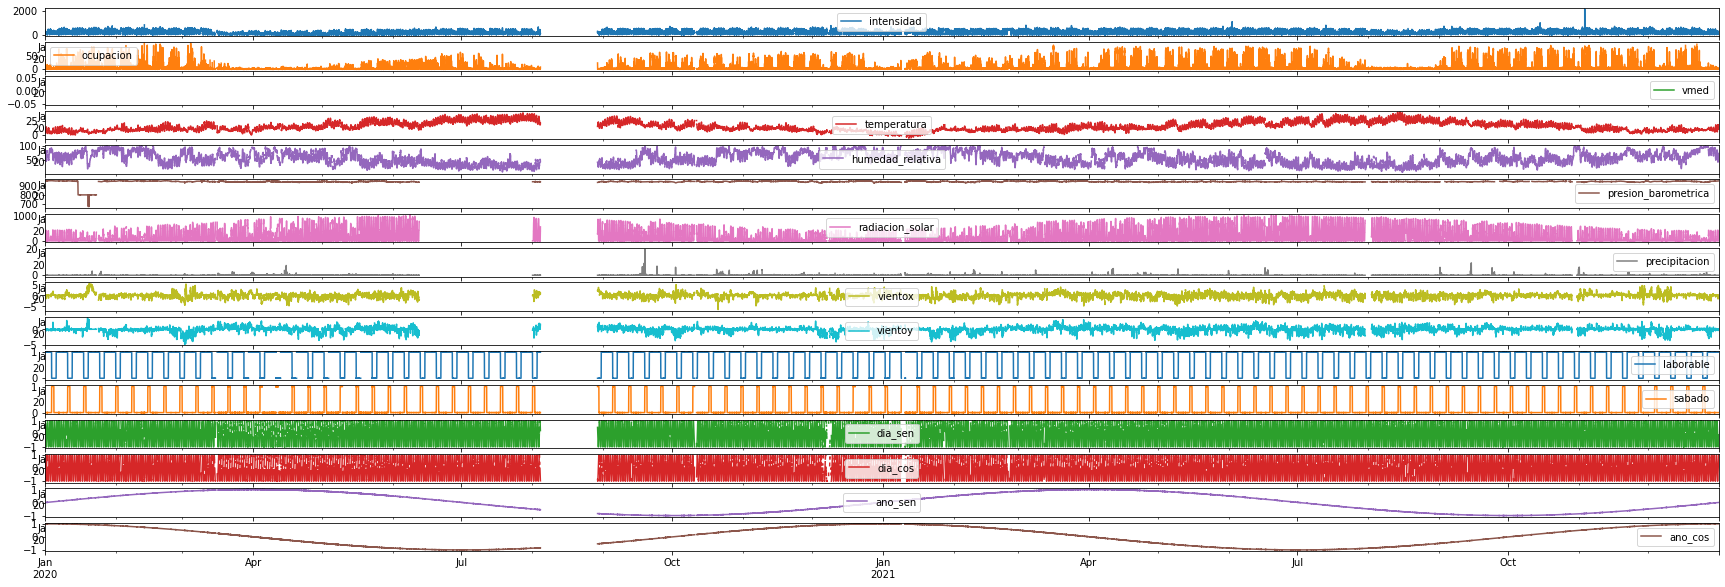

In [41]:
fig, ax = plt.subplots(figsize=(30, 10))
df.reindex(pd.date_range(df.index.min(), df.index.max(), freq="15min")).plot(subplots=True, ax=ax)
plt.show()

In [42]:
dfx = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq="15min"))

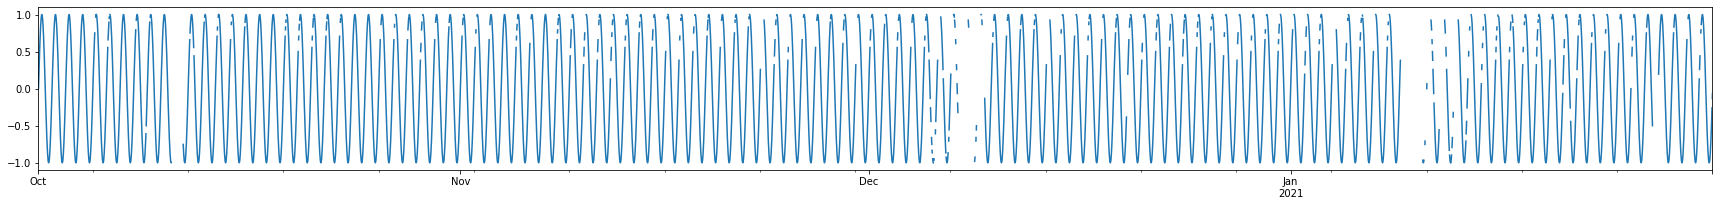

In [57]:
fig, ax = plt.subplots(figsize=(30, 3))
dfx.loc["2020-10-01":"2021-01-31"].dia_sen.plot(ax=ax)
plt.show()

In [52]:
dfx.loc["2021-04-01":"2021-04-01 06:15:00"]

intensidad  ocupacion  vmed  temperatura  \
2021-04-01 00:00:00        93.0        NaN   NaN         16.8   
2021-04-01 00:15:00        82.0        NaN   NaN         16.8   
2021-04-01 00:30:00        74.0        NaN   NaN         16.8   
2021-04-01 00:45:00        88.0        NaN   NaN         16.8   
2021-04-01 01:00:00        50.0        0.0   NaN         16.1   
2021-04-01 01:15:00        57.0        1.0   NaN         16.1   
2021-04-01 01:30:00        48.0        0.0   NaN         16.1   
2021-04-01 01:45:00        32.0        0.0   NaN         16.1   
2021-04-01 02:00:00        41.0        0.0   NaN         15.8   
2021-04-01 02:15:00        57.0        1.0   NaN         15.8   
2021-04-01 02:30:00        79.0        1.0   NaN         15.8   
2021-04-01 02:45:00        32.0        0.0   NaN         15.8   
2021-04-01 03:00:00        53.0        1.0   NaN         15.3   
2021-04-01 03:15:00        82.0        0.0   NaN         15.3   
2021-04-01 03:30:00        31.0        1.0   NaN         15.3   
2021-04-01 03:45:00        48.0        0.0   NaN         15.3   
2021-04-01 04:00:00        48.0        0.0   NaN         14.2   
2021-04-01 04:15:00         NaN        NaN   NaN          NaN   
2021-04-01 04:30:00         NaN        NaN   NaN          NaN   
2021-04-01 04:45:00       189.0        1.0   NaN         14.2   
2021-04-01 05:00:00         NaN        NaN   NaN          NaN   
2021-04-01 05:15:00         NaN        NaN   NaN          NaN   
2021-04-01 05:30:00        41.0        0.0   NaN         14.2   
2021-04-01 05:45:00         NaN        NaN   NaN          NaN   
2021-04-01 06:00:00        75.0        0.0   NaN         13.9   
2021-04-01 06:15:00        75.0        1.0   NaN         13.9   

                     humedad_relativa  presion_barometrica  radiacion_solar  \
2021-04-01 00:00:00              37.0                951.0              0.0   
2021-04-01 00:15:00              37.0                951.0              0.0   
2021-04-01 00:30:00              37.0                951.0              0.0   
2021-04-01 00:45:00              37.0                951.0              0.0   
2021-04-01 01:00:00              38.0                951.0              0.0   
2021-04-01 01:15:00              38.0                951.0              0.0   
2021-04-01 01:30:00              38.0                951.0              0.0   
2021-04-01 01:45:00              38.0                951.0              0.0   
2021-04-01 02:00:00              35.0                951.0              0.0   
2021-04-01 02:15:00              35.0                951.0              0.0   
2021-04-01 02:30:00              35.0                951.0              0.0   
2021-04-01 02:45:00              35.0                951.0              0.0   
2021-04-01 03:00:00              38.0                951.0              0.0   
2021-04-01 03:15:00              38.0                951.0              0.0   
2021-04-01 03:30:00              38.0                951.0              0.0   
2021-04-01 03:45:00              38.0                951.0              0.0   
2021-04-01 04:00:00              40.0                950.0              0.0   
2021-04-01 04:15:00               NaN                  NaN              NaN   
2021-04-01 04:30:00               NaN                  NaN              NaN   
2021-04-01 04:45:00              40.0                950.0              0.0   
2021-04-01 05:00:00               NaN                  NaN              NaN   
2021-04-01 05:15:00               NaN                  NaN              NaN   
2021-04-01 05:30:00              40.0                950.0              0.0   
2021-04-01 05:45:00               NaN                  NaN              NaN   
2021-04-01 06:00:00              37.0                950.0              0.0   
2021-04-01 06:15:00              37.0                950.0              0.0   

                     precipitacion   vientox   vientoy  laborable  sabado  \
2021-04-01 00:00:00            0.0 -1.658485  1.204960

/home/elena/PycharmProjects/tfm/tfm-env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


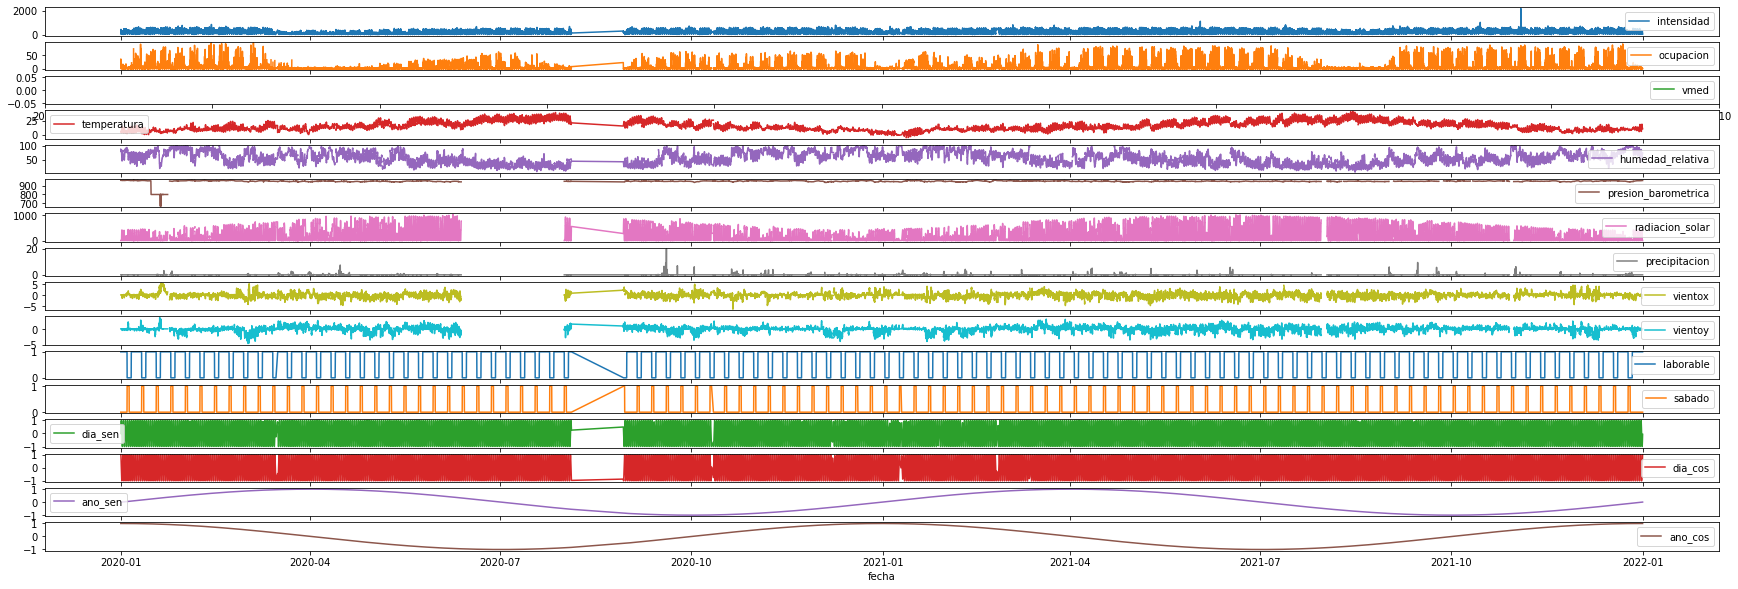

In [36]:
fig, ax = plt.subplots(figsize=(30, 10))
df.plot(subplots=True, ax=ax)
plt.show()

/home/elena/PycharmProjects/tfm/tfm-env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


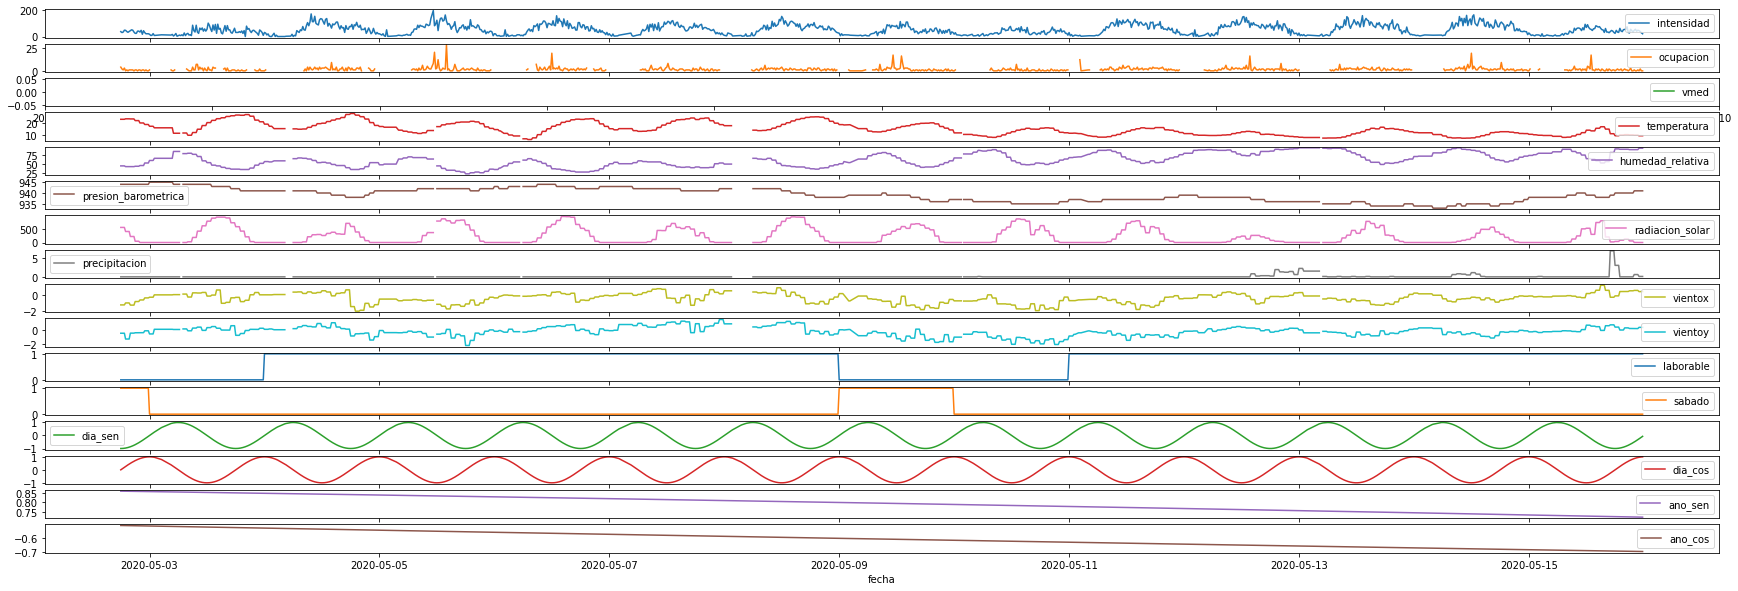

In [32]:
fig, ax = plt.subplots(figsize=(30, 10))
df.loc["2020-04-01":"2020-05-15"].plot(subplots=True, ax=ax)
plt.show()

In [5]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

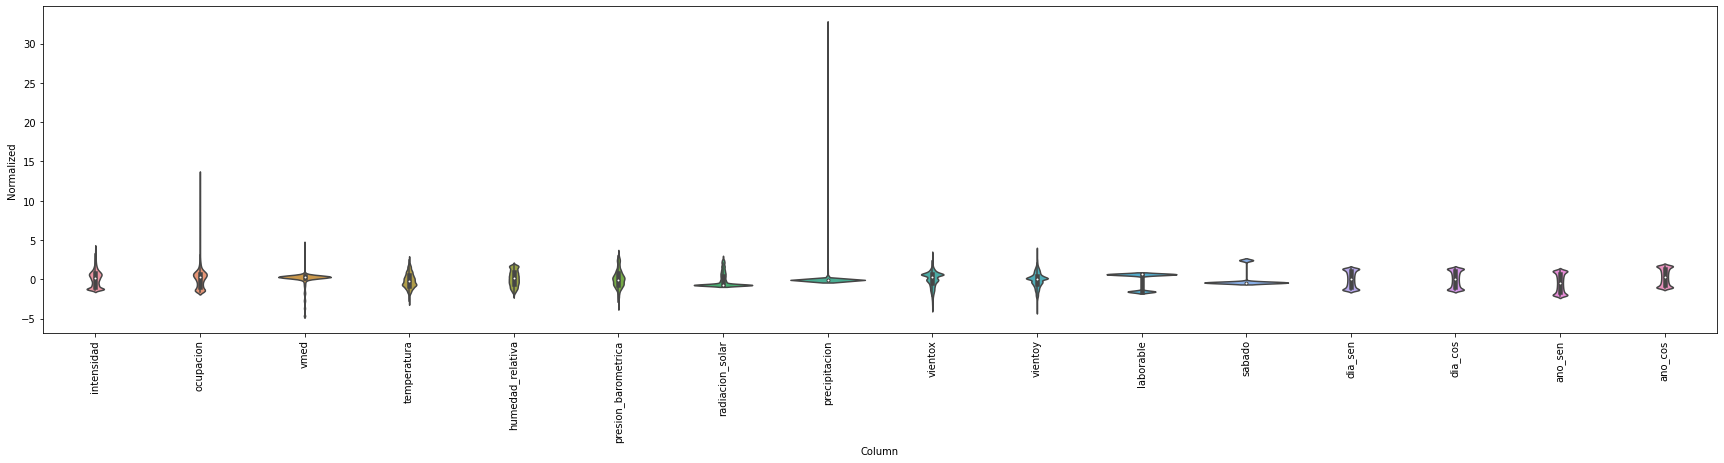

In [7]:
features_to_plot = ['intensidad', 'ocupacion', 'vmed']
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(30, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [8]:
train_df.describe()

intensidad     ocupacion          vmed   temperatura  \
count  2.196100e+04  1.977000e+04  2.172900e+04  2.318400e+04   
mean  -2.588380e-17 -8.050661e-17 -5.232033e-17 -5.099824e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.353733e+00 -1.630287e+00 -4.649476e+00 -3.015604e+00   
25%   -9.712574e-01 -9.242564e-01  1.741678e-01 -7.082463e-01   
50%    4.503613e-02  2.524617e-01  3.272994e-01 -5.360069e-02   
75%    6.788536e-01  7.231489e-01  4.038652e-01  7.298276e-01   
max    3.574744e+00  9.195519e+00  4.538417e+00  2.704496e+00   

       humedad_relativa  presion_barometrica  radiacion_solar  precipitacion  \
count      2.278200e+04         1.533500e+04     2.318400e+04   2.318400e+04   
mean      -3.992164e-17        -1.089792e-14    -2.942206e-17   1.471103e-17   
std        1.000000e+00         1.000000e+00     1.000000e+00   1.000000e+00   
min       -2.094525e+00        -3.343060e+00    -7.365903e-01  -1.131317e-01   
25%       -8.128630e-01        -7.190671e-01    -7.365903e-01  -1.131317e-01   
50%       -8.658802e-02        -6.306880e-02    -6.727909e-01  -1.131317e-01   
75%        8.105752e-01         5.929295e-01     6.468492e-01  -1.131317e-01   
max        1.878627e+00         3.435589e+00     2.765661e+00   3.254487e+01   

            vientox       vientoy     laborable        sabado       dia_sen  \
count  2.318400e+04  2.318400e+04  2.452200e+04  2.452200e+04  2.452200e+04   
mean   2.451838e-17 -4.413309e-17 -3.708893e-17 -1.657411e-16 -9.851747e-18   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.854629e+00 -4.114592e+00 -1.566896e+00 -4.115555e-01 -1.415712e+00   
25%   -5.949256e-01 -6.162201e-01 -1.566896e+00 -4.115555e-01 -1.001530e+00   
50%    2.073129e-01  7.959060e-02  6.381785e-01 -4.115555e-01 -1.604301e-03   
75%    7.060124e-01  5.719821e-01  6.381785e-01 -4.115555e-01  9.983209e-01   
max    3.286021e+00  3.780860e+00  6.381785e-01  2.429707e+00  1.412504e+00   

            dia_cos       ano_sen       ano_cos  
count  2.452200e+04  24522.000000  2.452200e+04  
mean   2.709230e-17      0.000000  7.417786e-17  
std    1.000000e+00      1.000000  1.000000e+00  
min   -1.414258e+00     -2.024363 -1.122592e+00  
25%   -1.000030e+00     -0.747364 -9.109924e-01  
50%    5.448147e-06      0.256980 -3.384658e-01  
75%    1.000041e+00      0.902067  9.555654e-01  
max    1.414269e+00      1.140710  1.754218e+00

In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}
for dfi in [train_df, val_df, test_df]:
    for c in tmagns + mmagns:
        dfi[f'missing_{c}'] = np.where(dfi[c].isnull(), 1, 0)
        dfi[c] = dfi[c].fillna(0)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24522 entries, 2021-01-01 00:00:00 to 2021-09-13 12:00:00
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   intensidad                   24522 non-null  float64
 1   ocupacion                    24522 non-null  float64
 2   vmed                         24522 non-null  float64
 3   temperatura                  24522 non-null  float64
 4   humedad_relativa             24522 non-null  float64
 5   presion_barometrica          24522 non-null  float64
 6   radiacion_solar              24522 non-null  float64
 7   precipitacion                24522 non-null  float64
 8   vientox                      24522 non-null  float64
 9   vientoy                      24522 non-null  float64
 10  laborable                    24522 non-null  float64
 11  sabado                       24522 non-null  float64
 12  dia_sen                      24522 non-

In [11]:
train_df.describe()

intensidad     ocupacion          vmed   temperatura  \
count  2.452200e+04  2.452200e+04  2.452200e+04  2.452200e+04   
mean  -2.318058e-17 -6.490562e-17 -4.636116e-17 -4.821561e-16   
std    9.463397e-01  8.978903e-01  9.413276e-01  9.723346e-01   
min   -1.353733e+00 -1.630287e+00 -4.649476e+00 -3.015604e+00   
25%   -8.510506e-01 -6.889128e-01  0.000000e+00 -6.760506e-01   
50%    0.000000e+00  0.000000e+00  2.507336e-01  0.000000e+00   
75%    6.023584e-01  4.878053e-01  4.038652e-01  6.761682e-01   
max    3.574744e+00  9.195519e+00  4.538417e+00  2.704496e+00   

       humedad_relativa  presion_barometrica  radiacion_solar  precipitacion  \
count      2.452200e+04         2.452200e+04     2.452200e+04   2.452200e+04   
mean      -3.708893e-17        -6.815091e-15    -2.781670e-17   1.390835e-17   
std        9.638674e-01         7.907854e-01     9.723346e-01   9.723346e-01   
min       -2.094525e+00        -3.343060e+00    -7.365903e-01  -1.131317e-01   
25%       -7.701410e-01        -2.817349e-01    -7.365903e-01  -1.131317e-01   
50%        0.000000e+00         0.000000e+00    -5.787708e-01  -1.131317e-01   
75%        7.251311e-01         1.555973e-01     5.427554e-01  -1.131317e-01   
max        1.878627e+00         3.435589e+00     2.765661e+00   3.254487e+01   

            vientox       vientoy  ...  missing_intensidad  missing_ocupacion  \
count  2.452200e+04  2.452200e+04  ...        24522.000000       24522.000000   
mean   2.318058e-17 -4.172504e-17  ...            0.104437           0.193785   
std    9.723346e-01  9.723346e-01  ...            0.305833           0.395271   
min   -3.854629e+00 -4.114592e+00  ...            0.000000           0.000000   
25%   -5.138900e-01 -5.647793e-01  ...            0.000000           0.000000   
50%    1.013462e-01  5.846194e-02  ...            0.000000           0.000000   
75%    6.848109e-01  5.172930e-01  ...            0.000000           0.000000   
max    3.286021e+00  3.780860e+00  ...            1.000000           1.000000   

       missing_vmed  missing_temperatura  missing_humedad_relativa  \
count  24522.000000         24522.000000              24522.000000   
mean       0.113898             0.054563                  0.070957   
std        0.317693             0.227130                  0.256758   
min        0.000000             0.000000                  0.000000   
25%        0.000000             0.000000                  0.000000   
50%        0.000000             0.000000                  0.000000   
75%        0.000000             0.000000                  0.000000   
max        1.000000             1.000000                  1.000000   

       missing_presion_barometrica  missing_radiacion_solar  \
count                 24522.000000             24522.000000   
mean                      0.374643                 0.054563   
std                       0.484041                 0.227130   
min                       0.000000                 0.000000   
25%                       0.000000                 0.000000   
50%                       0.000000                 0.000000   
75%                       1.000000                 0.000000   
max                       1.000000                 1.000000   

       missing_precipitacion  missing_vientox  missing_vientoy  
count           24522.000000     24522.000000     24522.000000  
mean                0.054563         0.054563         0.054563  
std                 0.227130         0.227130         0.227130  
min                 0.000000         0.000000         0.000000  
25%                 0.000000         0.000000         0.000000  
50%                 0.000000         0.000000         0.000000  
75%                 0.000000         0.000000         0.000000  
max                 1.000000         1.000000         1.000000  

[8 rows x 26 columns]

### Predicción
(copiado del tutorial de TensorFlow)

In [12]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
              self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


In [13]:
# Dadas 6 horas de datos, predice el tráfico exactamente seis horas después
w1 = WindowGenerator(input_width=6*4, label_width=1, shift=6*4, label_columns=['intensidad'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['intensidad']

In [14]:
# Dadas 4 horas datos, predice el tráfico 3 horas después, durante una hora
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['intensidad'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['intensidad']

In [15]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
third_length_df = train_df.shape[0] // 3
third_length_df

8174

In [17]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[third_length_df:third_length_df+w2.total_window_size]),
                           np.array(train_df[third_length_df:third_length_df+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

2022-02-22 09:12:40.069956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-22 09:12:40.070059: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-22 09:12:40.070143: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (elena-Aspire-ES1-521): /proc/driver/nvidia/version does not exist


All shapes are: (batch, time, features)
Window shape: (3, 7, 26)
Inputs shape: (3, 6, 26)
Labels shape: (3, 1, 1)


In [18]:
train_df.describe()

intensidad     ocupacion          vmed   temperatura  \
count  2.452200e+04  2.452200e+04  2.452200e+04  2.452200e+04   
mean  -2.318058e-17 -6.490562e-17 -4.636116e-17 -4.821561e-16   
std    9.463397e-01  8.978903e-01  9.413276e-01  9.723346e-01   
min   -1.353733e+00 -1.630287e+00 -4.649476e+00 -3.015604e+00   
25%   -8.510506e-01 -6.889128e-01  0.000000e+00 -6.760506e-01   
50%    0.000000e+00  0.000000e+00  2.507336e-01  0.000000e+00   
75%    6.023584e-01  4.878053e-01  4.038652e-01  6.761682e-01   
max    3.574744e+00  9.195519e+00  4.538417e+00  2.704496e+00   

       humedad_relativa  presion_barometrica  radiacion_solar  precipitacion  \
count      2.452200e+04         2.452200e+04     2.452200e+04   2.452200e+04   
mean      -3.708893e-17        -6.815091e-15    -2.781670e-17   1.390835e-17   
std        9.638674e-01         7.907854e-01     9.723346e-01   9.723346e-01   
min       -2.094525e+00        -3.343060e+00    -7.365903e-01  -1.131317e-01   
25%       -7.701410e-01        -2.817349e-01    -7.365903e-01  -1.131317e-01   
50%        0.000000e+00         0.000000e+00    -5.787708e-01  -1.131317e-01   
75%        7.251311e-01         1.555973e-01     5.427554e-01  -1.131317e-01   
max        1.878627e+00         3.435589e+00     2.765661e+00   3.254487e+01   

            vientox       vientoy  ...  missing_intensidad  missing_ocupacion  \
count  2.452200e+04  2.452200e+04  ...        24522.000000       24522.000000   
mean   2.318058e-17 -4.172504e-17  ...            0.104437           0.193785   
std    9.723346e-01  9.723346e-01  ...            0.305833           0.395271   
min   -3.854629e+00 -4.114592e+00  ...            0.000000           0.000000   
25%   -5.138900e-01 -5.647793e-01  ...            0.000000           0.000000   
50%    1.013462e-01  5.846194e-02  ...            0.000000           0.000000   
75%    6.848109e-01  5.172930e-01  ...            0.000000           0.000000   
max    3.286021e+00  3.780860e+00  ...            1.000000           1.000000   

       missing_vmed  missing_temperatura  missing_humedad_relativa  \
count  24522.000000         24522.000000              24522.000000   
mean       0.113898             0.054563                  0.070957   
std        0.317693             0.227130                  0.256758   
min        0.000000             0.000000                  0.000000   
25%        0.000000             0.000000                  0.000000   
50%        0.000000             0.000000                  0.000000   
75%        0.000000             0.000000                  0.000000   
max        1.000000             1.000000                  1.000000   

       missing_presion_barometrica  missing_radiacion_solar  \
count                 24522.000000             24522.000000   
mean                      0.374643                 0.054563   
std                       0.484041                 0.227130   
min                       0.000000                 0.000000   
25%                       0.000000                 0.000000   
50%                       0.000000                 0.000000   
75%                       1.000000                 0.000000   
max                       1.000000                 1.000000   

       missing_precipitacion  missing_vientox  missing_vientoy  
count           24522.000000     24522.000000     24522.000000  
mean                0.054563         0.054563         0.054563  
std                 0.227130         0.227130         0.227130  
min                 0.000000         0.000000         0.000000  
25%                 0.000000         0.000000         0.000000  
50%                 0.000000         0.000000         0.000000  
75%                 0.000000         0.000000         0.000000  
max                 1.000000         1.000000         1.000000  

[8 rows x 26 columns]

In [19]:
example_inputs[2]

<tf.Tensor: shape=(6, 26), dtype=float64, numpy=
array([[-1.31002188, -1.63028718, -0.82118723, -1.11605828,  0.68240903,
         0.        , -0.73659031, -0.11313171,  0.25114431, -0.37721748,
        -1.56689587,  2.42970687,  1.26667048,  0.62551817,  1.13346079,
         0.45177745,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.32094976, -1.63028718, -1.81654231, -1.11605828,  0.68240903,
         0.        , -0.73659031, -0.11313171,  0.25114431, -0.37721748,
        -1.56689587,  2.42970687,  1.304861  ,  0.54122063,  1.1334882 ,
         0.45152083,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.18981512, -1.63028718,  0.71012827, -1.11605828,  0.68240903,
         0.        , -0.73659031, -0.11313171,  0.25114431, -0.37721748,
        -1.56689587,  2.4297068

In [20]:
w2.example = example_inputs, example_labels

In [21]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

w1.example = example_inputs, example_labels

All shapes are: (batch, time, features)
Window shape: (3, 48, 26)
Inputs shape: (3, 24, 26)
Labels shape: (3, 1, 1)


In [22]:
def plot(self, model=None, plot_col='intensidad', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

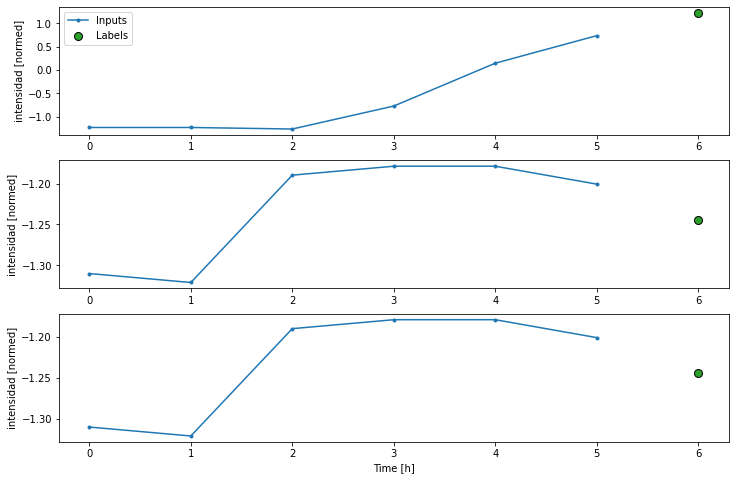

In [23]:
w2.plot(plot_col='intensidad')

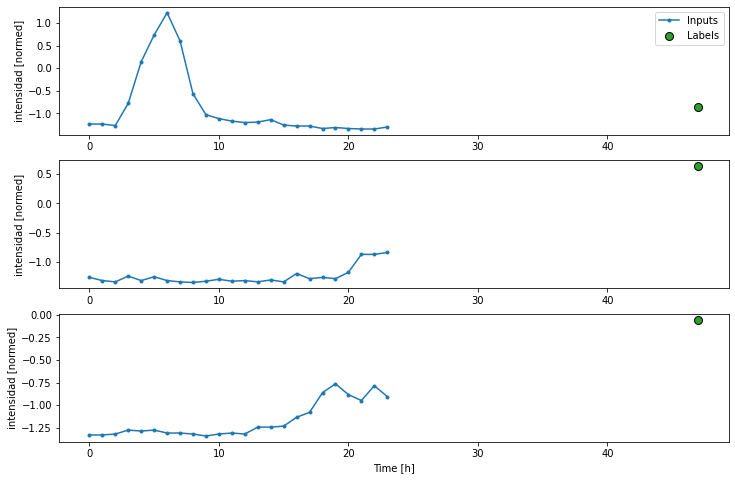

In [24]:
w1.plot(plot_col='intensidad')

In [25]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset


In [26]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [27]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 26), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [28]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 26)
Labels shape (batch, time, features): (32, 1, 1)


In [29]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['intensidad'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['intensidad']

In [30]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 26)
Labels shape (batch, time, features): (32, 1, 1)


In [31]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [32]:
baseline = Baseline(label_index=column_indices['intensidad'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

219/219 [==============================] - 3s 9ms/step - loss: 0.0958 - mean_absolute_error: 0.1781


In [33]:
train_df.shape[0] / 32

766.3125

In [34]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['intensidad'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['intensidad']

In [35]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 26)
Output shape: (32, 24, 1)


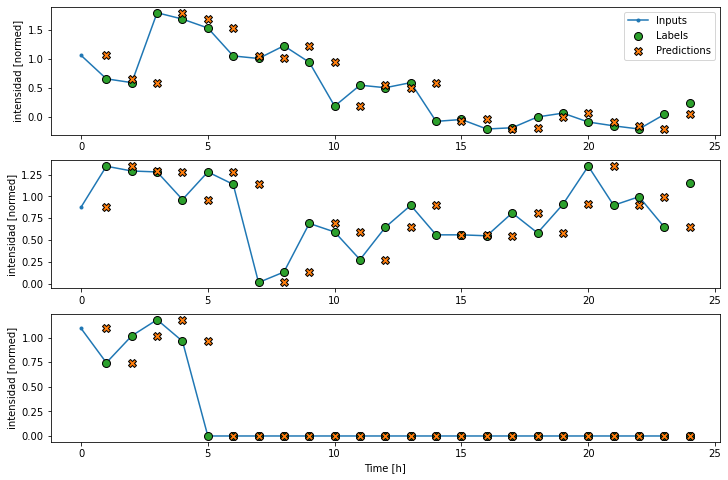

In [36]:
wide_window.plot(baseline)

In [37]:
linear = tf.keras.Sequential([
    #tf.keras.layers.Masking(mask_value=-5),
    tf.keras.layers.Dense(units=1)
])

In [38]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 26)
Output shape: (32, 1, 1)


In [39]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [40]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['intensidad']

In [41]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
767/767 [==============================] - 13s 16ms/step - loss: 0.3507 - mean_absolute_error: 0.4075 - val_loss: 0.3111 - val_mean_absolute_error: 0.3365
Epoch 2/20
767/767 [==============================] - 15s 20ms/step - loss: 0.1121 - mean_absolute_error: 0.2315 - val_loss: 0.1572 - val_mean_absolute_error: 0.2429- mean_absolute_error: - ETA: 0s - loss: 0.1128 - mean_absolute_erro
Epoch 3/20
767/767 [==============================] - 15s 20ms/step - loss: 0.0885 - mean_absolute_error: 0.2062 - val_loss: 0.1182 - val_mean_absolute_error: 0.2137: 1s - loss:
Epoch 4/20
767/767 [==============================] - 17s 23ms/step - loss: 0.0838 - mean_absolute_error: 0.1996 - val_loss: 0.1057 - val_mean_absolute_error: 0.2032
Epoch 5/20
767/767 [==============================] - 17s 22ms/step - loss: 0.0826 - mean_absolute_error: 0.1977 - val_loss: 0.0995 - val_mean_absolute_error: 0.1980
Epoch 6/20
767/767 [==============================] - 14s 17ms/step - loss: 0.0822 - mean_

In [42]:
train_df.shape[0]/32

766.3125

In [43]:
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['intensidad']

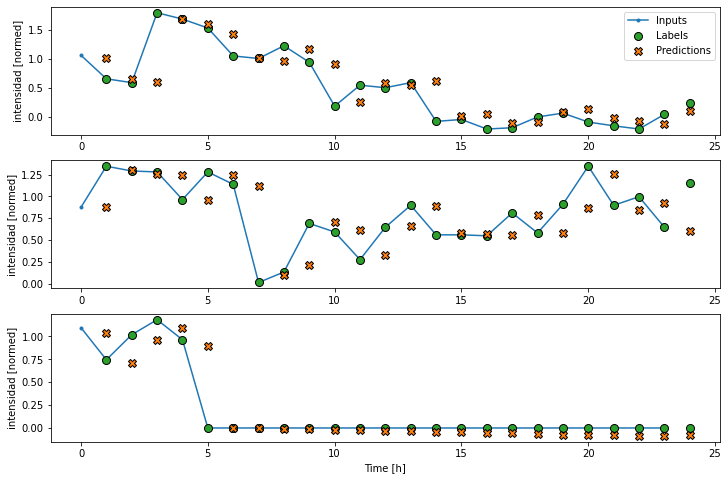

In [44]:
wide_window.plot(linear)

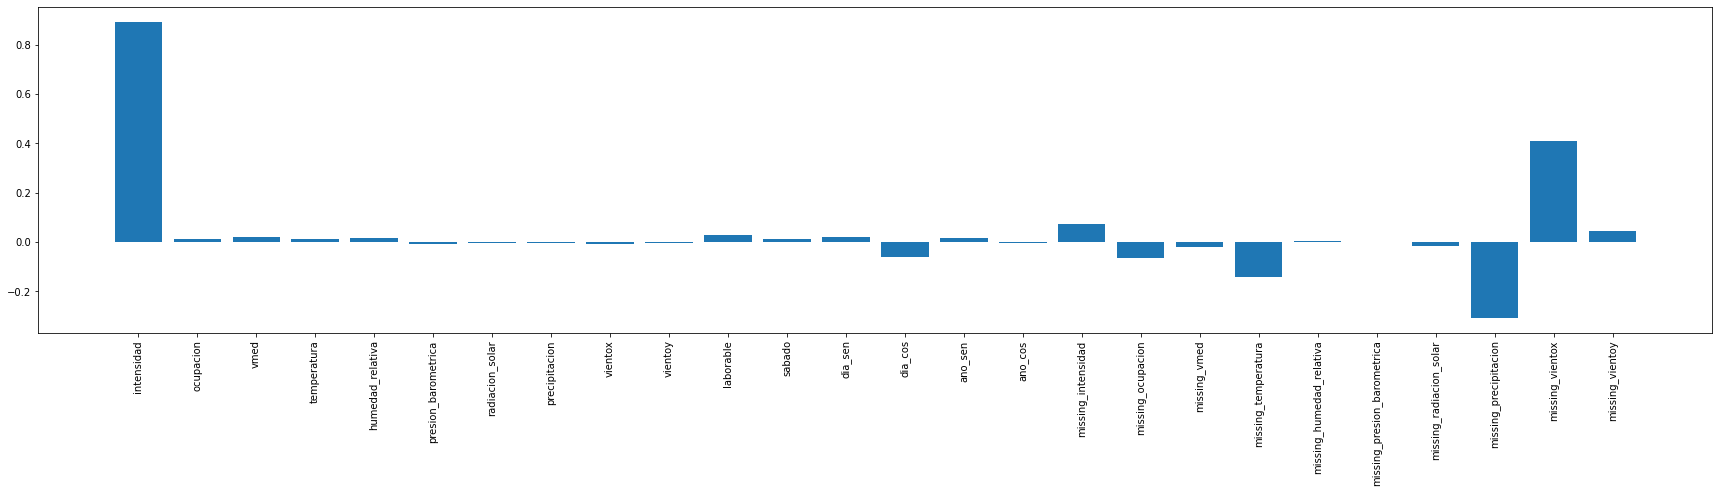

In [45]:
fig, ax = plt.subplots(figsize=(30, 6))
ax.bar(x=range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
ax.set_xticks(range(len(train_df.columns)))
_ = ax.set_xticklabels(train_df.columns, rotation=90)


In [46]:
linear.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 1)           27        
                                                                 
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


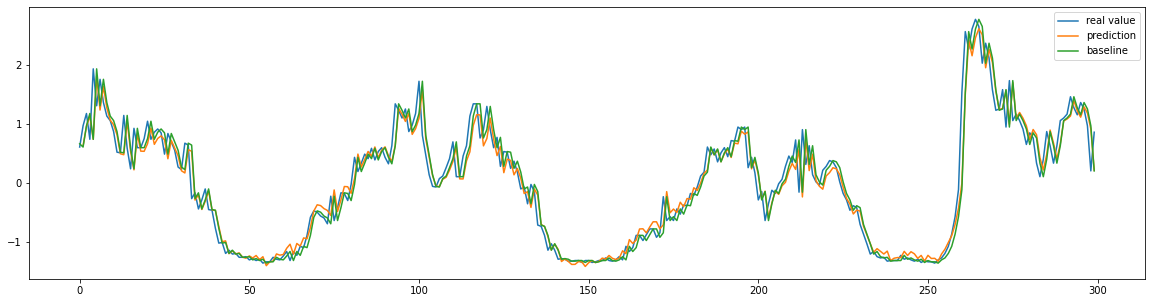

In [47]:
mini = 6100
maxi = 6400
fig, ax = plt.subplots(figsize=(20, 5))
train_df.iloc[mini:maxi].reset_index().intensidad.plot(ax=ax, label="real value")
pd.Series(linear.predict(train_df.iloc[mini:maxi].values).ravel()).shift(1).plot(ax=ax, label="prediction")
train_df.shift(1).iloc[mini:maxi].reset_index().intensidad.plot(ax=ax, label="baseline")
plt.legend()
plt.show()

In [48]:
train_df.iloc[mini:mini+3]

intensidad  ocupacion      vmed  temperatura  \
fecha                                                               
2021-03-05 13:45:00    0.613286   0.487805  0.327299    -0.558000   
2021-03-05 14:00:00    0.973907   0.958492  0.403865    -0.472145   
2021-03-05 14:15:00    1.181536   0.723149  0.480431    -0.472145   

                     humedad_relativa  presion_barometrica  radiacion_solar  \
fecha                                                                         
2021-03-05 13:45:00          0.596965                  0.0         0.354715   
2021-03-05 14:00:00          0.468799                  0.0         0.717364   
2021-03-05 14:15:00          0.468799                  0.0         0.717364   

                     precipitacion   vientox  vientoy  ...  \
fecha                                                  ...   
2021-03-05 13:45:00      -0.113132  1.388804  1.15299  ...   
2021-03-05 14:00:00      -0.113132  0.855014  1.35958  ...   
2021-03-05 14:15:00      -0.113132  0.855014  1.35958  ...   

                     missing_intensidad  missing_ocupacion  missing_vmed  \
fecha                                                                      
2021-03-05 13:45:00                   0                  0             0   
2021-03-05 14:00:00                   0                  0             0   
2021-03-05 14:15:00                   0                  0             0   

                     missing_temperatura  missing_humedad_relativa  \
fecha                                                                
2021-03-05 13:45:00                    0                         0   
2021-03-05 14:00:00                    0                         0   
2021-03-05 14:15:00                    0                         0   

                     missing_presion_barometrica  missing_radiacion_solar  \
fecha                                                                       
2021-03-05 13:45:00                            1                        0   
2021-03-05 14:00:00                            1                        0   
2021-03-05 14:15:00                            1                        0   

                     missing_precipitacion  missing_vientox  missing_vientoy  
fecha                                                                         
2021-03-05 13:45:00                      0                0                0  
2021-03-05 14:00:00                      0                0                0  
2021-03-05 14:15:00                      0                0                0  

[3 rows x 26 columns]

In [49]:
linear.predict(np.array(
    train_df.iloc[mini:mini+3].values
))

array([[0.63588256],
       [0.96041185],
       [1.1403176 ]], dtype=float32)

In [50]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
767/767 [==============================] - 17s 18ms/step - loss: 0.0979 - mean_absolute_error: 0.2166 - val_loss: 0.1131 - val_mean_absolute_error: 0.2344
Epoch 2/20
767/767 [==============================] - 11s 15ms/step - loss: 0.0678 - mean_absolute_error: 0.1829 - val_loss: 0.0918 - val_mean_absolute_error: 0.1996
Epoch 3/20
767/767 [==============================] - 9s 11ms/step - loss: 0.0639 - mean_absolute_error: 0.1764 - val_loss: 0.0975 - val_mean_absolute_error: 0.2048
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.1017 - mean_absolute_error: 0.2074: 0s - loss: 0.0996 - mean_absolute_err


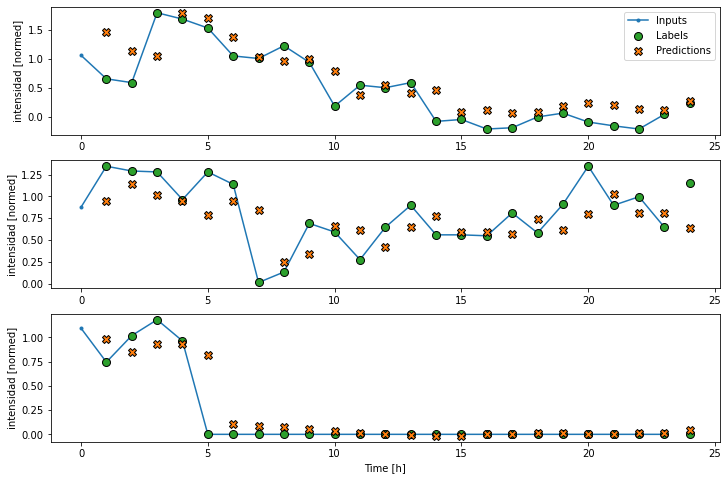

In [51]:
wide_window.plot(dense)

In [52]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['intensidad'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['intensidad']

Text(0.5, 1.0, 'Given 45 minutes of inputs, predict 15 minutes into the future.')

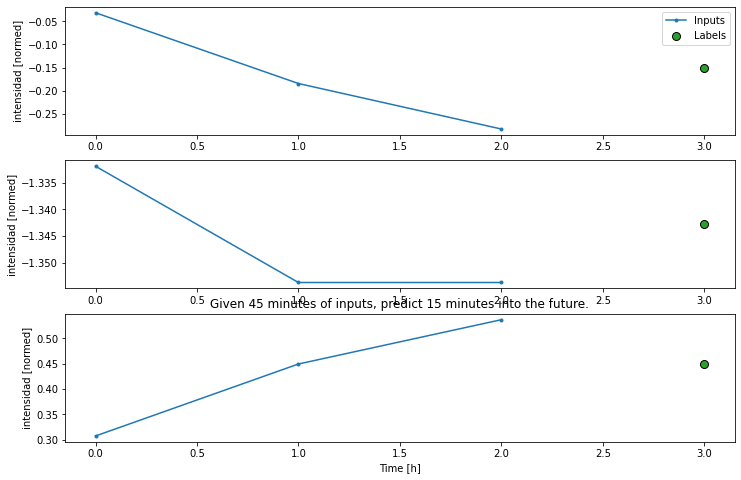

In [53]:
conv_window.plot()
plt.title("Given 45 minutes of inputs, predict 15 minutes into the future.")

In [54]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [55]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 26)
Output shape: (32, 1, 1)


In [56]:
history = compile_and_fit(multi_step_dense, conv_window)

#IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
767/767 [==============================] - 17s 19ms/step - loss: 0.1332 - mean_absolute_error: 0.2513 - val_loss: 0.1360 - val_mean_absolute_error: 0.2588
Epoch 2/20
767/767 [==============================] - 11s 15ms/step - loss: 0.0715 - mean_absolute_error: 0.1906 - val_loss: 0.1155 - val_mean_absolute_error: 0.2381
Epoch 3/20
767/767 [==============================] - 16s 21ms/step - loss: 0.0657 - mean_absolute_error: 0.1806 - val_loss: 0.1148 - val_mean_absolute_error: 0.2353
Epoch 4/20
767/767 [==============================] - 11s 14ms/step - loss: 0.0626 - mean_absolute_error: 0.1755 - val_loss: 0.1153 - val_mean_absolute_error: 0.2408
Epoch 5/20
767/767 [==============================] - 21s 27ms/step - loss: 0.0610 - mean_absolute_error: 0.1725 - val_loss: 0.1033 - val_mean_absolute_error: 0.2180
Epoch 6/20
767/767 [==============================] - 12s 16ms/step - loss: 0.0596 - mean_absolute_error: 0.1700 - val_loss: 0.1056 - val_mean_absolute_error: 0.2233
Epoc

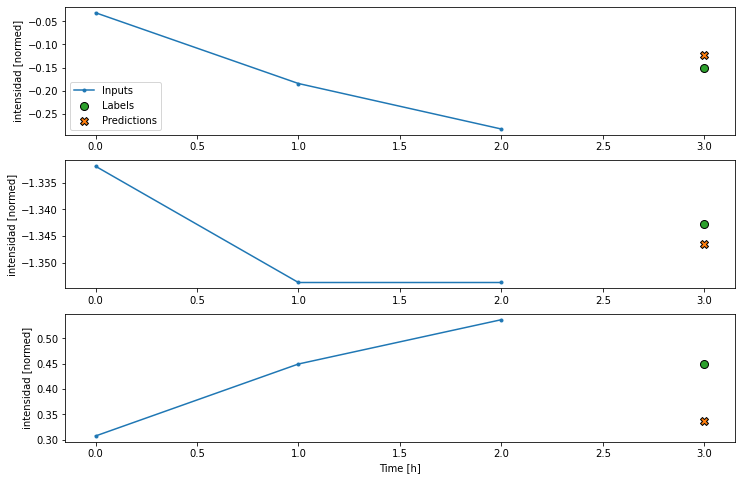

In [57]:
conv_window.plot(multi_step_dense)

In [58]:
LONG_CONV_WIDTH = 7*24*4
long_conv_window = WindowGenerator(
    input_width=LONG_CONV_WIDTH,
    label_width=1,
    shift=24,
    label_columns=['intensidad'])

long_conv_window

Total window size: 696
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

Text(0.5, 1.0, 'Given 7 days of inputs, predict one day into the future.')

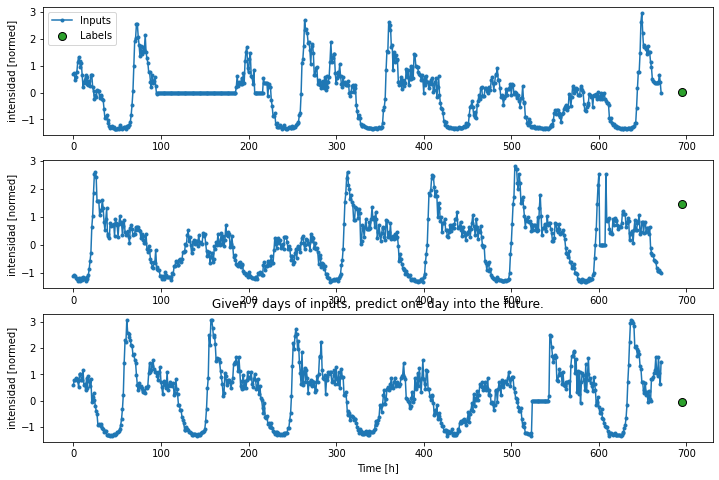

In [59]:
long_conv_window.plot()
plt.title("Given 7 days of inputs, predict one day into the future.")

In [60]:
long_multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [61]:
print('Input shape:', long_conv_window.example[0].shape)
print('Output shape:', long_multi_step_dense(long_conv_window.example[0]).shape)

Input shape: (32, 672, 26)
Output shape: (32, 1, 1)


In [62]:
history = compile_and_fit(long_multi_step_dense, long_conv_window)

#IPython.display.clear_output()
val_performance['Long multi step dense'] = long_multi_step_dense.evaluate(long_conv_window.val)
performance['Long multi step dense'] = long_multi_step_dense.evaluate(long_conv_window.test, verbose=0)

Epoch 1/20
745/745 [==============================] - 42s 53ms/step - loss: 0.4101 - mean_absolute_error: 0.4569 - val_loss: 1.6088 - val_mean_absolute_error: 0.9802
Epoch 2/20
745/745 [==============================] - 34s 45ms/step - loss: 0.1434 - mean_absolute_error: 0.2842 - val_loss: 1.0560 - val_mean_absolute_error: 0.8102
Epoch 3/20
745/745 [==============================] - 33s 45ms/step - loss: 0.1072 - mean_absolute_error: 0.2427 - val_loss: 1.0042 - val_mean_absolute_error: 0.7591
Epoch 4/20
745/745 [==============================] - 44s 59ms/step - loss: 0.0921 - mean_absolute_error: 0.2257 - val_loss: 0.9816 - val_mean_absolute_error: 0.7830
Epoch 5/20
745/745 [==============================] - 44s 59ms/step - loss: 0.0824 - mean_absolute_error: 0.2136 - val_loss: 1.1726 - val_mean_absolute_error: 0.8481
Epoch 6/20
745/745 [==============================] - 37s 50ms/step - loss: 0.0790 - mean_absolute_error: 0.2100 - val_loss: 0.9182 - val_mean_absolute_error: 0.7267
Epoc

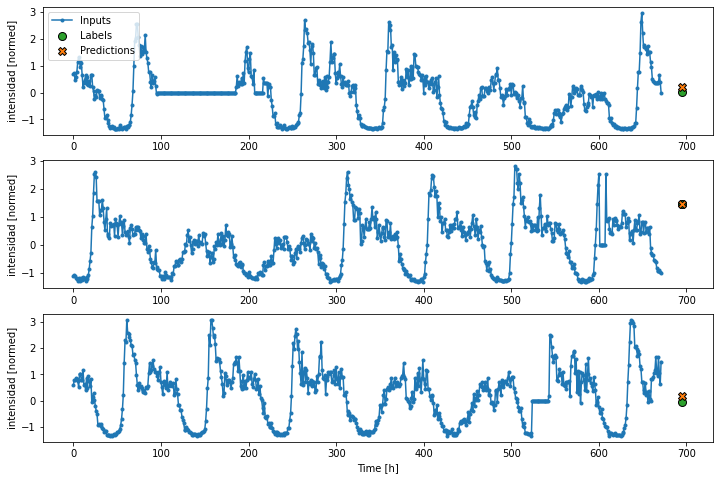

In [63]:
long_conv_window.plot(long_multi_step_dense)

In [64]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 26)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1of input shape to have value 78, but received input with shape (32, 624)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 26), dtype=float32)
  • training=None
  • mask=None


In [65]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [66]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 26)
Output shape: (32, 1, 1)


In [68]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

219/219 [==============================] - 2s 9ms/step - loss: 0.0970 - mean_absolute_error: 0.2135


In [69]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 26)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [70]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['intensidad'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['intensidad']

In [71]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window
Input shape: (32, 26, 26)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


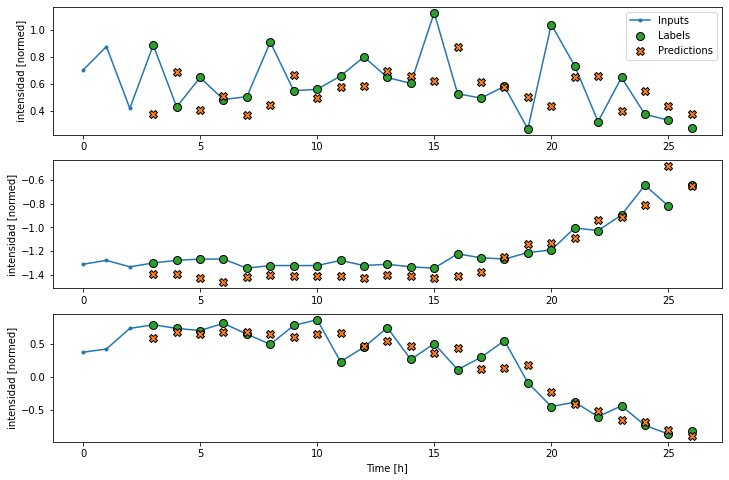

In [72]:
wide_conv_window.plot(conv_model)

In [73]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [74]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 26)
Output shape: (32, 24, 1)


In [75]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

219/219 [==============================] - 4s 19ms/step - loss: 0.0955 - mean_absolute_error: 0.2046


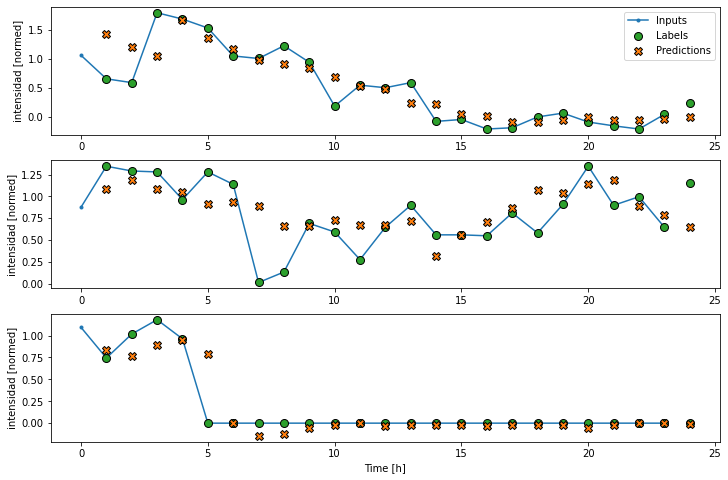

In [76]:
wide_window.plot(lstm_model)

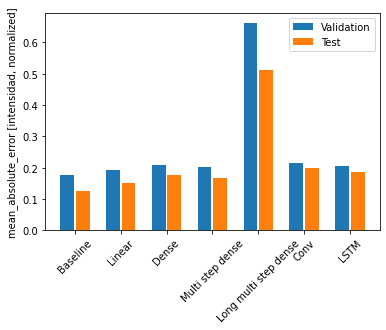

In [84]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [intensidad, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [85]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


Baseline    : 0.1266
Linear      : 0.1514
Dense       : 0.1774
Multi step dense: 0.1658
Long multi step dense: 0.5129
Conv        : 0.1977
LSTM        : 0.1852


In [32]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 26)
Labels shape (batch, time, features): (32, 24, 26)


In [33]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [34]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

219/219 [==============================] - 2s 8ms/step - loss: 0.0603 - mean_absolute_error: 0.0464


In [35]:
num_features = train_df.shape[1]
num_features

26

In [36]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [37]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): None

In [40]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

219/219 [==============================] - 2s 8ms/step - loss: 0.0723 - mean_absolute_error: 0.1053


In [41]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

219/219 [==============================] - 3s 13ms/step - loss: 0.0722 - mean_absolute_error: 0.0840

CPU times: user 7min 12s, sys: 41.2 s, total: 7min 53s
Wall time: 4min 11s


In [42]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each time step is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [43]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

219/219 [==============================] - 3s 13ms/step - loss: 0.0637 - mean_absolute_error: 0.0597

CPU times: user 3min 41s, sys: 22 s, total: 4min 3s
Wall time: 1min 58s


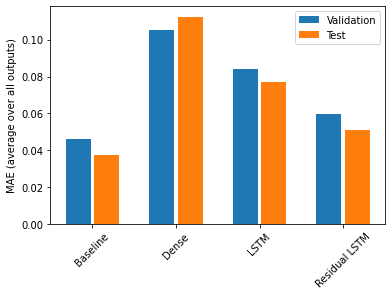

In [45]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [46]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.0376
Dense          : 0.1124
LSTM           : 0.0770
Residual LSTM  : 0.0509


Total window size: 192
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): None

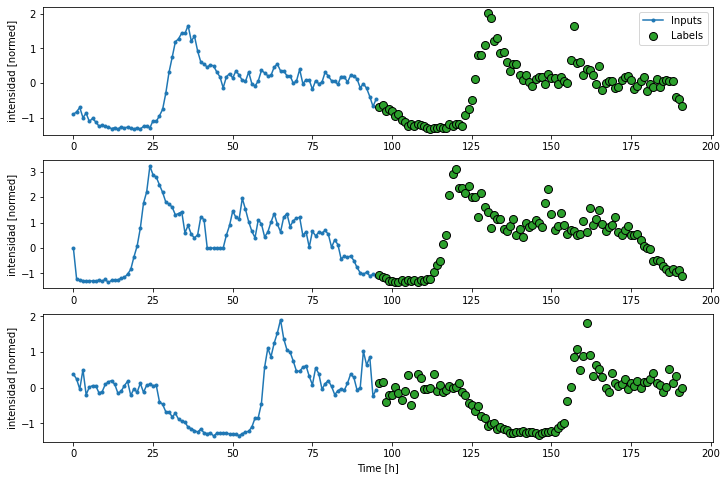

In [47]:
INPUT_STEPS = 24*4
OUT_STEPS = 24*4
multi_window = WindowGenerator(input_width=INPUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

213/213 [==============================] - 3s 11ms/step - loss: 0.8315 - mean_absolute_error: 0.3749


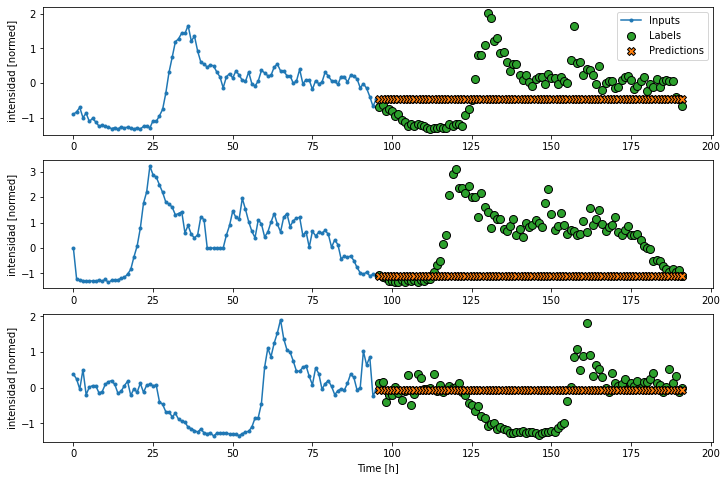

In [48]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

213/213 [==============================] - 3s 10ms/step - loss: 0.5840 - mean_absolute_error: 0.2364


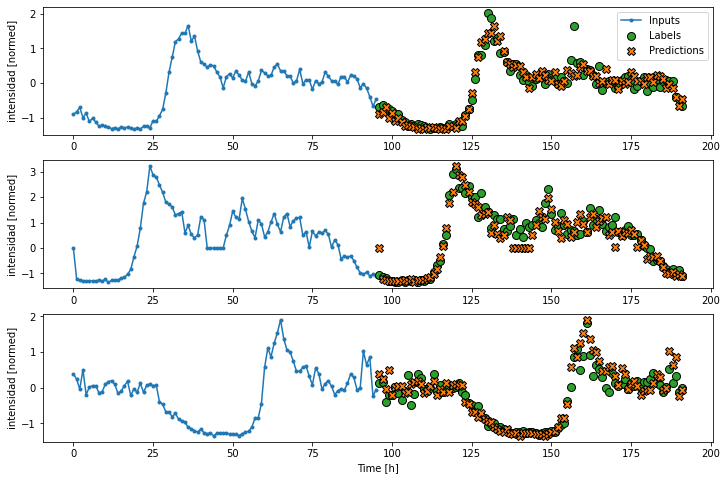

In [49]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)


213/213 [==============================] - 7s 31ms/step - loss: 0.3412 - mean_absolute_error: 0.2423: 


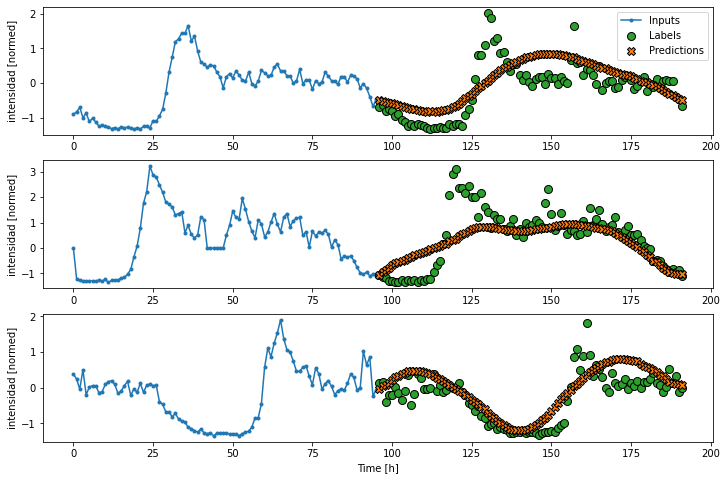

In [50]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

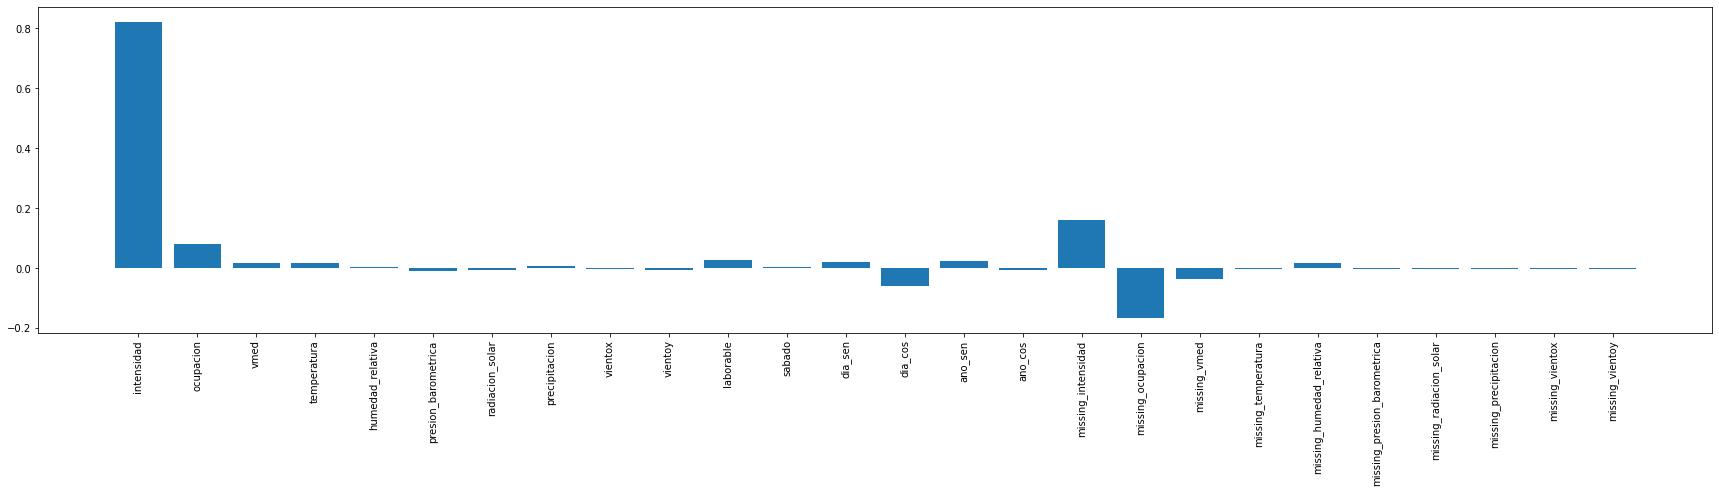

In [52]:
fig, ax = plt.subplots(figsize=(30, 6))
ax.bar(x=range(len(train_df.columns)),
        height=multi_linear_model.layers[1].kernel[:,0].numpy())
ax.set_xticks(range(len(train_df.columns)))
_ = ax.set_xticklabels(train_df.columns, rotation=90)

213/213 [==============================] - 9s 43ms/step - loss: 0.3271 - mean_absolute_error: 0.2594


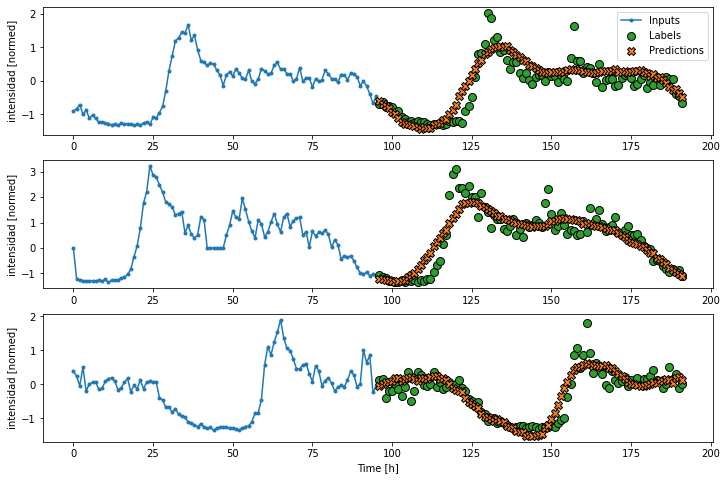

In [51]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

213/213 [==============================] - 8s 39ms/step - loss: 0.3262 - mean_absolute_error: 0.2637


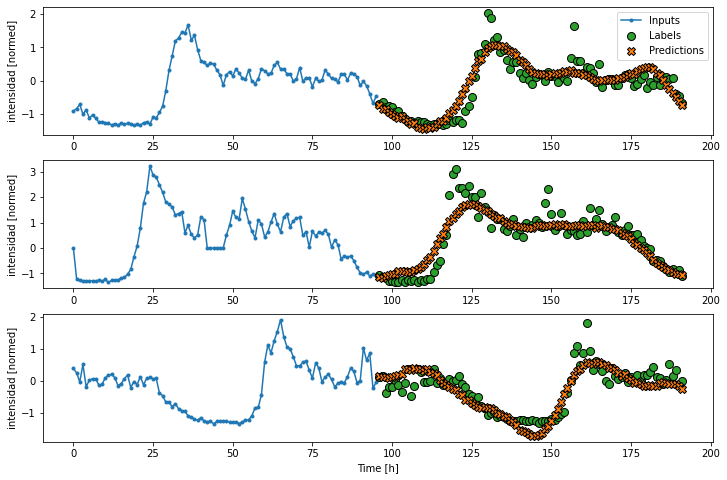

In [58]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

213/213 [==============================] - 10s 47ms/step - loss: 0.3788 - mean_absolute_error: 0.3313


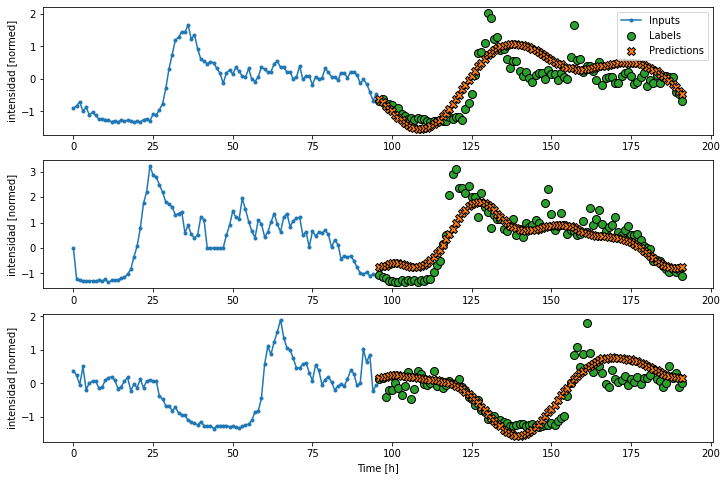

In [59]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [60]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [61]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [62]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [63]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 26])

In [64]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call


In [65]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 96, 26)


213/213 [==============================] - 15s 69ms/step - loss: 0.4767 - mean_absolute_error: 0.3722


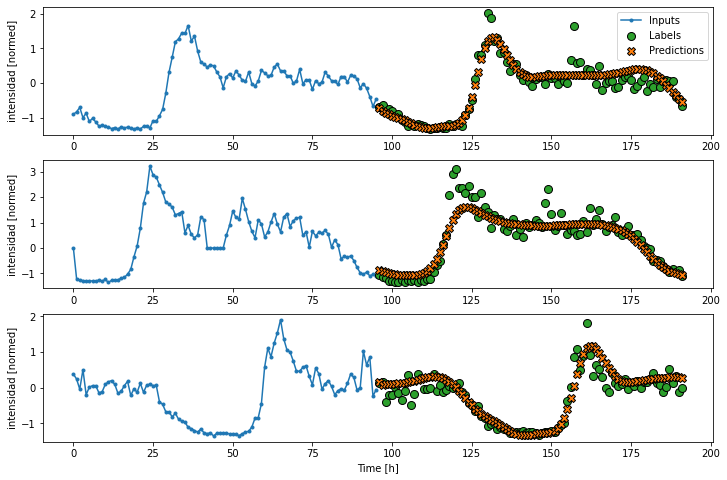

In [66]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

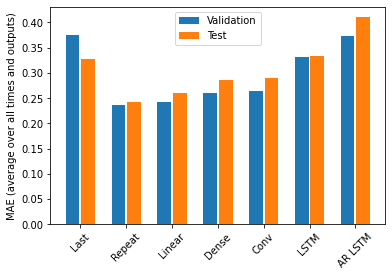

In [67]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [68]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.3280
Repeat  : 0.2416
Linear  : 0.2603
Dense   : 0.2866
Conv    : 0.2906
LSTM    : 0.3338
AR LSTM : 0.4107


In [69]:
multi_performance.items()

dict_items([('Last', [0.5197378993034363, 0.3279670178890228]), ('Repeat', [0.3893281817436218, 0.2416323572397232]), ('Linear', [0.24489568173885345, 0.2603332996368408]), ('Dense', [0.26420000195503235, 0.28664150834083557]), ('Conv', [0.2589813768863678, 0.2905588150024414]), ('LSTM', [0.28765609860420227, 0.3338365852832794]), ('AR LSTM', [0.4317028522491455, 0.41068658232688904])])